# Devoir 1

In [77]:
import numpy as np
import matplotlib.pyplot as plt

## Les bandits stochastiques

### [10 points] Les environnements de bandits stochastiques

#### Récompenses de distributions de Bernoulli

Complétez le code suivant pour implémenter un simulateur de bandit stochastique à $k$ actions avec récompenses générées par des distributions de Bernoulli. Votre classe doit recevoir en entrée les probabilités de succès de chaque action ainsi qu'un germe aléatoire permettant de fixer la réalisation de l'instance. La fonction _play_ doit échantillonner et retourner une récompense pour l'action demandée.

In [78]:
class BernoulliBandit:
    
    def __init__(self, probabilities, seed=None):
        self.probabilities = probabilities
        self.rng = np.random.default_rng(seed)

        self.n = len(probabilities)
        self.optimal_action = np.argmax(probabilities)
        self.optimal_reward = probabilities[self.optimal_action]

        self.action_history = []
        self.reward_history = []

    def play(self, action):
        action_reward = self.rng.binomial(1, self.probabilities[action])

        self.action_history.append(action)
        self.reward_history.append(action_reward)
        return action_reward

Générez une instance de votre environnement avec la configuration $\boldsymbol \mu = (0.7, 0.6, 0.5)$.

In [79]:
instance = BernoulliBandit([0.7, 0.6, 0.5])

Montrez que votre environnement fonctionne en jouant 100 fois chaque action sur votre instance. Collectez les récompenses et présentez-les sous la forme d'une figure pour chaque action. Affichez la moyenne empirique pour chaque action.

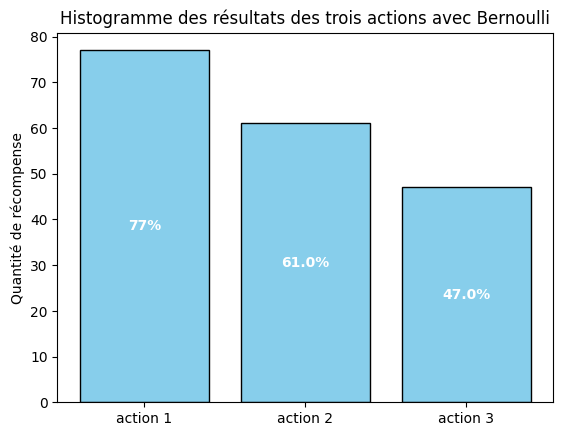

In [80]:
resultatAction1 = np.mean([instance.play(0) for _ in range(100)])
resultatAction2 = np.mean([instance.play(1) for _ in range(100)])
resultatAction3 = np.mean([instance.play(2) for _ in range(100)])

valeurs = [resultatAction1*100, resultatAction2*100, resultatAction3*100]
moyennes = [str(round(resultatAction1 * 100)) + "%", str(round(resultatAction2 * 100,1)) + "%", str(round(resultatAction3*100,1)) +"%"]
description = ['action 1', 'action 2', 'action 3']


x = np.arange(len(valeurs))

plt.bar(x, valeurs, color='skyblue', edgecolor='black')


for i, (v, desc) in enumerate(zip(valeurs, moyennes)):
    plt.text(i, v/2, desc, ha='center', va='center', color='white', fontsize=10, fontweight='bold')

plt.xticks(x, description)
plt.ylabel("Quantité de récompense")
plt.title("Histogramme des résultats des trois actions avec Bernoulli")

plt.show()

#### Récompenses de distributions normales

Complétez le code suivant pour implémenter un simulateur de bandit stochastique à $k$ actions avec récompenses générées par des distributions normales. Votre classe doit recevoir en entrée l'espérance et la variance des récompenses pour chaque action, ainsi qu'un germe aléatoire permettant de fixer la réalisation de l'instance. La fonction _play_ doit échantillonner et retourner une récompense pour l'action demandée.

In [81]:
class NormalBandit(BernoulliBandit):

    def __init__(self, means, variances, seed=None):
        super().__init__([0] * len(means), seed)  # on n'utilise pas les probabilités du BernoulliBandit
        self.means = means
        self.variances = variances

    def play(self, action):
        action_reward = self.rng.normal(self.means[action], np.sqrt(self.variances[action]))
        self.action_history.append(action)
        self.reward_history.append(action_reward)

        return action_reward


Générez une instance de votre environnement avec la configuration $\boldsymbol \mu = (0.7, 0.6, 0.5)$ et une variance de récompenses $\sigma^2 = 1$ pour toutes les actions.

In [82]:
instance_normal = NormalBandit([0.7, 0.6, 0.5], [1, 1, 1])

Montrez que votre environnement fonctionne en jouant 100 fois chaque action sur votre instance. Collectez les récompenses et affichez la moyenne et la variance empiriques pour chaque action.

In [83]:
a0 = [instance_normal.play(0) for _ in range(100)]
a1 = [instance_normal.play(1) for _ in range(100)]
a2 = [instance_normal.play(2) for _ in range(100)]

print('la moyenne de a0 est ', round(np.mean(a0), 2), 'et la variance est ', round(np.var(a0), 2))
print('la moyenne de a1 est ', round(np.mean(a1), 2), 'et la variance est ', round(np.var(a1), 2))
print('la moyenne de a2 est ', round(np.mean(a2), 2), 'et la variance est ', round(np.var(a2), 2))

la moyenne de a0 est  0.68 et la variance est  1.05
la moyenne de a1 est  0.78 et la variance est  0.84
la moyenne de a2 est  0.55 et la variance est  1.21


### [10 points] Explore-Then-Commit (ETC)

Complétez le code suivant pour implémenter la stratégie ETC. Votre fonction doit recevoir en entrée l'instance de bandit à aborder, la durée de l'horizon de temps $T$, ainsi que la durée $m$ de la phase exploratoire accordée pour chaque action.

In [84]:
def etc(bandit: BernoulliBandit, T, m):
    actions_history = []
    n = bandit.n

    # Phase d'exploration
    for i in range(n):
        for _ in range(m):
            actions_history.append(i)
            bandit.play(i)

    mean_rewards = [np.mean([r for a, r in zip(bandit.action_history, bandit.reward_history) if a == i]) for i in range(n)]
    # Trouver l'action optimale
    optimal = np.argmax(mean_rewards)

    # Phase d'exploitation
    for _ in range(T - n * m):
        actions_history.append(optimal)
        bandit.play(optimal)

    return np.cumsum([max(bandit.probabilities) - bandit.probabilities[a] for a in actions_history])

Considérez l'instance de bandits $\boldsymbol \mu = (0.7, 0.6, 0.5)$ avec récompenses générées par des distributions de Bernoulli. Appliquez la stratégie ETC sur $N=100$ réalisations de cette instance sur un horizon temporel $T = 2000$. Comparez ETC pour $m=50$ tirages exploratoires par action avec ETC pour $m$ optimal selon la théorie : $$m_\text{optimal} = \left\lceil \frac{4 \sigma^2}{\Delta_-^2} \ln \left( \frac{T \Delta_-^2}{4 \sigma^2} \right) \right\rceil \quad \text{avec } \Delta_- = \min_{a\neq a_\star} \Delta_a$$

Supposez que le gap de sous-optimalité minimal $\Delta_-$ est connu.

Présentez une figure montrant le pseudo-regret cumulatif moyenné sur les réalisations, avec un écart-type au-dessus, pour chaque configuration de la stratégie. Affichez le pourcentage des réalisations pour lesquelles chaque variante a pu exploiter l'action optimale.

le m_optimal est :  300
Pourcentage de réalisations qui converge vers action optimale m=50: 90.00%
Pourcentage de réalisations qui converge vers action optimale m=300: 100.00%


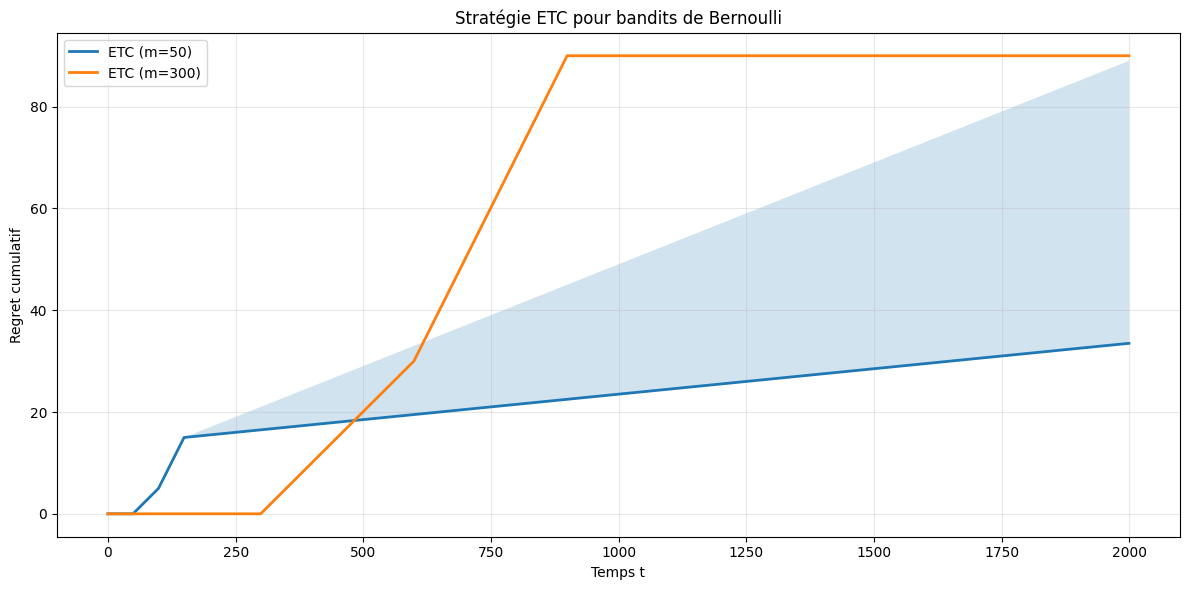

In [106]:
# Pour les distributions de Bernoulli, la variance maximale est 0.25
T = 2000
N = 100

sigma_squared = 0.25  
delta_minus = 0.7 - 0.6  
m_optimal = int(np.ceil((4 * sigma_squared / delta_minus**2) * np.log((T * delta_minus**2) / (4 * sigma_squared))))
print("le m_optimal est : ", m_optimal)
m_values = [50, m_optimal]

plt.figure(figsize=(12, 6))

for m in m_values:
    regrets_all = [etc(BernoulliBandit(probabilities=[0.7, 0.6, 0.5], seed=i), T, m) for i in range(N)]
    mean_regrets = np.mean(regrets_all, axis=0)
    std_regrets = np.std(regrets_all, axis=0)

    last_regrets_change = [regrets[-1]-regrets[-2] for regrets in regrets_all]
    pourcentage_optimal_m300 = sum(1 for change in last_regrets_change if change == 0) / N * 100
    print(f"Pourcentage de réalisations qui converge vers action optimale m={m}: {pourcentage_optimal_m300:.2f}%")

    plt.plot(mean_regrets, label=f"ETC (m={m})", linewidth=2)
    plt.fill_between(range(len(mean_regrets)), mean_regrets, mean_regrets + std_regrets, alpha=0.2)
    plt.xlabel("Temps t")
    plt.ylabel("Regret cumulatif")
    plt.title("Stratégie ETC pour bandits de Bernoulli")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()


plt.show()


Expliquez les régimes observés sur les courbes ainsi que les différences entre les courbes. Supportez votre discussion à l'aide des taux de convergence à l'action optimale obtenus avec chaque valeur de $m$.

Pour les deux courbe on observe une première phase d'exploration découper en trois sections, une pour chaque action. La croissance du pseudo regret dépend de chaque action: la pente est nulle pour l'action optimal, sinon croissant. En fait, la pente est égale au pseudo regret instantané.

Ensuite, on peut voir la phase d'exploitation dont la pente est égale au pseudo regret instantané de l'action choisi au terme de la phase d'exploration.
Pour m optimal de 300 100% des réalisation converge vers l'action optimal, nous avons donc aucune accumulation de regret pour toutes les instance du problème une fois la phase d'exploration complétée. Comme l'action choisie est toujours la même sur toute la courbe, l'écart type demeure nulle.

Pour m=50, 90% des realisation convergent vers l'action optimale, ce qui veut dire que 10% des réalisations choisissent la mauvaise action. On obtient donc une croissance linéaire du regret cumulatif. La pente résultante de cette courbe est une combinaison du pseudo regret instantané des actions et elle se situe entre 0 et 0,2. L'écart-type croit aussi de façon linéaire avec une pente plus accentuée que celle du pseudo regret.

On peut conclure que dans le cas étudié, il serait éventuellement plus avantageux de procéder à une phase d'exploration plus longue que 50 pour un T >> 0

__[IFT-7201]__ Montrez comment obtenir l'équation de $m$ optimal sur un environnement à $k = 3$ actions.

Seulement pour François Duguay-Giguère


Objectif est de minimiser le regret cumulatif. mu1 > mu2 > mu3

exprimer sous forme de formule le regret final.

regret = m * (delta_2 + delta_3) + (t-(m*3)) * [delta_1 Pr(A = 2) + delta_2 Pr(A = 3)]

On fait l'hypothèse du pire cas où delta_2 = delta_3

et on obtient

regret = 2 * m * (delta_2) + (t - k * (m*3)) * 2 * [delta_2 Pr(A = 1)]

regret <= 2 * m * (delta_2) + (t - k * (m*3)) * 2 * delta_2 * Pr( mû2(k.m) >= mû1(k.m))

regret = 2 * m * (delta_2) + (t - k * (m*3)) * 2 * delta_2 * Pr( mû2(k.m) >= mû1(k.m) >= 0)

regret = 2 * m * (delta_2) + (t - k * (m*3)) * 2 * delta_2 * Pr( mû2(k.m) >= mû1(k.m) >= delta_2)

regret = 2 * m * (delta_2) + (t - k * (m*3)) * 2 * delta_2 * Pr( mû2(k.m) >= mû1(k.m) >= delta_2)

regret = 2 * m * (delta_2) + (t - k * (m*3)) * 2 * delta_2 * Pr( mû2(k.m) - mu2  - (mû1(k.m) - mu1) >= delta_2)

hypothèse: récompenses suivent des lois sigma sous-gaussiennes

regret = 2 * m * (delta_2) + (t - k * (m*3)) * 2 * delta_2 * (exp((- m * delta2**2)/4 * sigma**2))

hypothèse: pour t >> k * m * 3

regret = 2 * m * (delta_2) +  2 * delta_2 * (t) * (exp((- m * delta2**2)/4 * sigma**2))

on dérive le regret par rapport à m et cherche la solution au point maximum, la dérivé = 0

2 * delta_2 - delta_2**3 * T * exp((- m * delta2**2)/4 * sigma**2) / 4 * sigma**2 = 0

on met le m en évidence dans l'expression exponentiel,  on laisse tomber le 2 du  2 * delta parce que delta_2 déjà petit comme mentionné précédemment

et on obtient la même expression pour le calcul de m

$$m_\text{optimal} = \left\lceil \frac{4 \sigma^2}{\Delta_-^2} \ln \left( \frac{T \Delta_-^2}{4 \sigma^2} \right) \right\rceil \quad \text{avec } \Delta_- = \min_{a\neq a_\star} \Delta_a$$








### [10 points] $\varepsilon$-greedy

Complétez le code suivant pour implémenter la stratégie $\varepsilon$-greedy avec taux d'exploration $\varepsilon$ fixe. Votre fonction doit recevoir en entrée l'instance de bandit à aborder, la durée de l'horizon de temps $T$, ainsi que le taux d'exploration $\varepsilon$.

In [86]:
def egreedy(bandit, T, epsilon, seed=None):
    rng = np.random.default_rng(seed)
    actions_history = []
    count_actions = np.zeros(bandit.n)
    means_actions = np.zeros(bandit.n)

    action = None
    for t in range(T):
        if t < bandit.n:
            action = t  

        else:
            if rng.random() < epsilon:
                action = rng.integers(bandit.n)  
            else:
                action = np.argmax(means_actions)
        
        actions_history.append(action)

        reward = bandit.play(action)
        count_actions[action] += 1
        means_actions[action] = ((count_actions[action]-1) * means_actions[action] + reward) / count_actions[action]

    return actions_history

Considérez l'instance de bandits $\boldsymbol \mu = (0.7, 0.6, 0.5)$ avec récompenses générées par des distributions de Bernoulli. Appliquez la stratégie $\varepsilon$-greedy sur $N=100$ réalisations de cette instance sur un horizon temporel $T = 1000$. Comparez $\varepsilon$-greedy pour $\varepsilon \in \{0, 1/8, 1/4, 1/2, 1\}$.

Présentez une figure montrant le pseudo-regret cumulatif moyenné sur les réalisations, avec un écart-type au-dessus, pour chaque configuration de la stratégie. Affichez le nombre de fois en moyenne (avec un écart-type) où l'action optimale est sélectionnée sur l'instance considérée avec chaque configuration de la stratégie.

Pour epsilon=0, action optimale sélectionnée en moyenne: 629.4 +/- 473.6
Pour epsilon=0.125, action optimale sélectionnée en moyenne: 826.4 +/- 163.1
Pour epsilon=0.25, action optimale sélectionnée en moyenne: 795.0 +/- 87.4
Pour epsilon=0.5, action optimale sélectionnée en moyenne: 632.5 +/- 63.0
Pour epsilon=1, action optimale sélectionnée en moyenne: 333.5 +/- 15.7


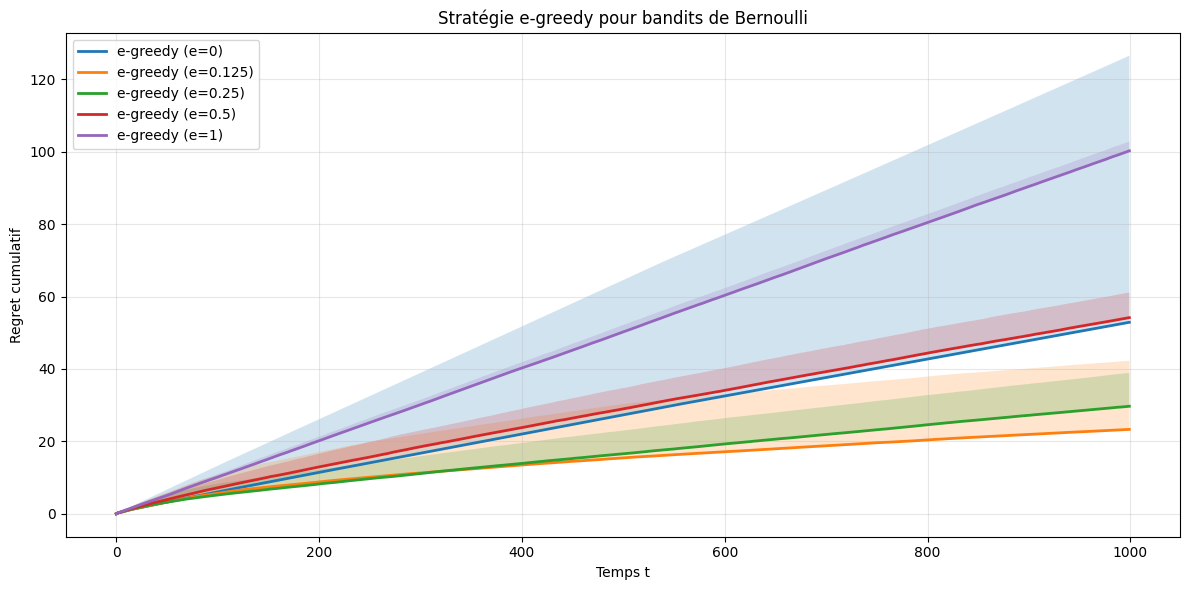

In [107]:
N = 100
T = 1000

epsilons = [0, 1/8, 1/4, 1/2, 1]

plt.figure(figsize=(12, 6))

for e in epsilons:
    probabilities=[0.7, 0.6, 0.5]
    action_history = [egreedy(BernoulliBandit(probabilities=probabilities, seed=i), T, e, seed=i) for i in range(N)]

    optimal_Action = np.argmax(probabilities)
    count_optimal_actions = [actions.count(optimal_Action) for actions in action_history]
    print(f"Pour epsilon={e}, action optimale sélectionnée en moyenne: {np.mean(count_optimal_actions):.1f} +/- {np.std(count_optimal_actions):.1f}")


    regrets_all = [np.cumsum([max(probabilities) - probabilities[a] for a in actions]) for actions in action_history]
    mean_regrets = np.mean(regrets_all, axis=0)
    std_regrets = np.std(regrets_all, axis=0)


    plt.plot(mean_regrets, label=f"e-greedy (e={e})", linewidth=2)
    plt.fill_between(range(len(mean_regrets)), mean_regrets, mean_regrets + std_regrets, alpha=0.2)
    plt.xlabel("Temps t")
    plt.ylabel("Regret cumulatif")
    plt.title("Stratégie e-greedy pour bandits de Bernoulli")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()

plt.show()

Expliquez les différences observées entre les courbes. Expliquez les nombres de tirages de l'action optimale en référant aux bornes inférieures sur le pseudo-regret cumulatif de la stratégie $\varepsilon$-greedy pour les configurations $\varepsilon = 0$ et $\varepsilon = 1$.

Intuitivement, trop d'exploration ajoute du regret comme l'action optimal n'est pas choisi. Aucune des valeurs d'epsilon ne donnent des courbes qui convergent vers un plateau.


epsilon 1 correspond à seulement de l'Exploration et epsilon 0 seulement de l'exploitation, donc en mode greedy. Dans les deux cas il n'y a pas d'apprentissage et la courbe du pseudo regret est linéaire.

epsilon 0, correspond à du greedy pure. La même action est choisie à chaque temps suivant la phase d'exploration. L'action optimale est choisi aléatoirement. Comme les action sont proche on observe un grand écart type.

epsilon 1 va donc choisir une action aléatoire à chaque temps, dans un environnement à 3 actions, il choisira l'action optimal 1/3 (333). Peu de variance, donc petit écart-type. On peut projeter que la pente de la droite correspondra à une moyenne des trois pseudo regrets instantanés. Ainsi l'écart-type devrait être constant.



### [10 points] UCB

Complétez le code suivant pour implémenter la stratégie UCB1 (Auer et al., 2002). Votre fonction doit recevoir en entrée l'instance de bandit à aborder ainsi que la durée de l'horizon de temps $T$.

In [108]:
def ucb1(bandit, T):
    actions_history = []

    actions_mean_rewards = np.zeros(bandit.n)
    actions_count = np.zeros(bandit.n)
    
    for t in range(T):
        action = 0
        if t < bandit.n:
            action = t
        else:
            # incertitude delta 1/t**4
            exploration = np.sqrt((2 * np.log(t)) / actions_count)
            prediction = actions_mean_rewards + exploration
            action = np.argmax(prediction)
        
        actions_history.append(action)

        reward = bandit.play(action)
        
        actions_count[action] += 1
        actions_mean_rewards[action] = (actions_mean_rewards[action] * (actions_count[action] - 1) + reward) / actions_count[action]



    return np.cumsum([max(bandit.probabilities) - bandit.probabilities[a] for a in actions_history])

Considérez l'instance de bandits $\boldsymbol \mu = (0.7, 0.6, 0.5)$ avec récompenses générées par des distributions de Bernoulli. Appliquez la stratégie UCB1 sur $N=100$ réalisations de cette instance sur un horizon temporel $T = 1000$.

Présentez une figure montrant le pseudo-regret cumulatif moyenné sur les réalisations, avec un écart-type au-dessus.

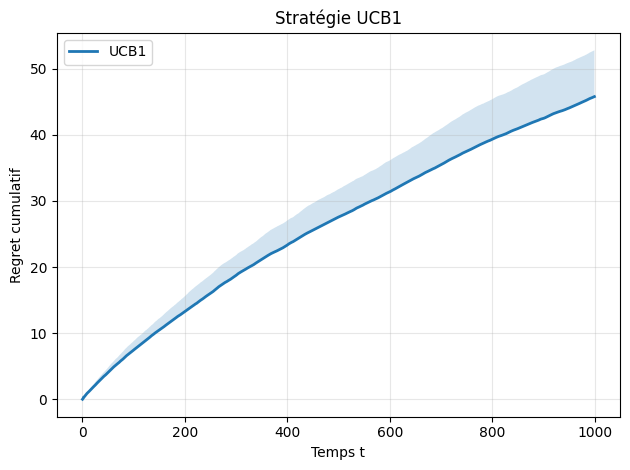

In [109]:
N = 100
T = 1000

all_regrets = [ucb1(BernoulliBandit([0.7, 0.6, 0.5]), T) for _ in range(N)]

mean = np.mean(all_regrets, axis=0)
std = np.std(all_regrets, axis=0)
plt.plot(mean, label=f"UCB1", linewidth=2)
plt.fill_between(range(len(mean)), mean, mean + std, alpha=0.2)

plt.xlabel("Temps t")
plt.ylabel("Regret cumulatif")
plt.title("Stratégie UCB1")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Expliquez la forme de la courbe obtenue.

La courbe a une forme logarithmique qui devrait converger vers une valeur à l'infinie, donc un très bon apprentissage. 

Cela est dû au terme d'exploration qui diminue avec le temps (la sélection des action)

La pente est encore raide, car nous somme encore dans une phase d'exploration (le terme d'exploration est encore grand), t=5000 donne une courbe qui tend vers un plateau.

### [10 points] Thompson Sampling (TS)

Complétez le code suivant pour implémenter la stratégie TS destinée à des bandits stochastiques dont les récompenses suivent des distributions normales de variance connue $\sigma^2$. Votre fonction doit recevoir en entrée l'instance de bandit à aborder, la durée de l'horizon de temps $T$, la valeur des paramètres a priori ($\mu_0$ et $\sigma_0$), ainsi que la variance des observations ($\sigma^2$).

In [91]:
def ts_normal(bandit, T, mu_0, sigma_0, sigma):
    actions_history = []
    n = bandit.n
    
    mu_posts = np.array([mu_0] * n, dtype=float)
    sigma_posts = np.array([sigma_0] * n, dtype=float)
    
    for t in range(T):
        theta_samples = np.random.normal(mu_posts, sigma_posts)
        action = np.argmax(theta_samples)
        

        reward = bandit.play(action)
        actions_history.append(action)
        
        precision_prior = 1 / (sigma_posts[action] ** 2)
        precision_obs = 1 / (sigma ** 2)
        precision_post = precision_prior + precision_obs
        
        mu_posts[action] = (precision_prior * mu_posts[action] + precision_obs * reward) / precision_post
        sigma_posts[action] = np.sqrt(1 / precision_post)

    return np.cumsum([max(bandit.means) - bandit.means[a] for a in actions_history])


Considérez la classe d'environnements à 10 actions dont les récompenses suivent des distributions normales de variance $\sigma^2 = 1$ et dont les configurations sont telles que $\mu_a \sim \mathcal N(2, 1)$. Appliquez la stratégie TS à 100 instances de cette classe (une réalisation par instance) sur un horizon temporel $T = 1000$.

Présentez une figure montrant le pseudo-regret cumulatif moyenné sur les réalisations, avec un écart-type au-dessus.

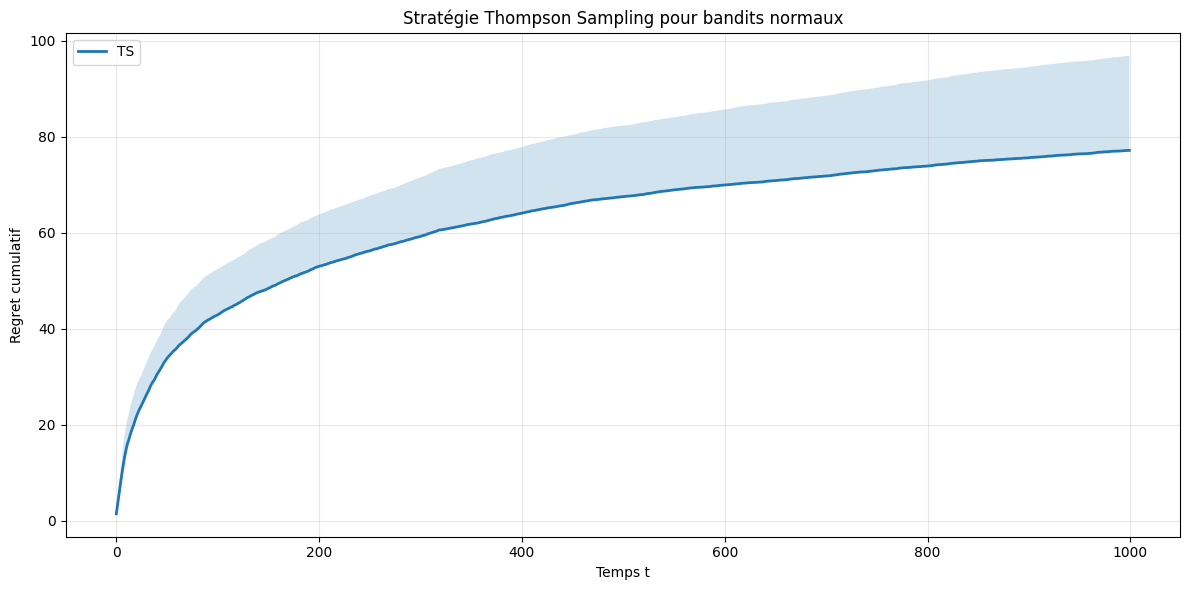

In [92]:
N = 100
T = 1000
sigma = 1
mu_0 = 2
sigma_0 = 10

regrets_all = [ts_normal(NormalBandit(np.random.normal(2, 1, 10), [1]*10, seed=1), T, mu_0, sigma_0, sigma) for _ in range(N)]
mean_regrets = np.mean(regrets_all, axis=0)
std_regrets = np.std(regrets_all, axis=0)


plt.figure(figsize=(12, 6))
plt.plot(mean_regrets, label="TS", linewidth=2)
plt.fill_between(range(len(mean_regrets)), mean_regrets, mean_regrets + std_regrets, alpha=0.2)
plt.xlabel("Temps t")
plt.ylabel("Regret cumulatif")
plt.title("Stratégie Thompson Sampling pour bandits normaux")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Justifiez le choix des paramètres a priori utilisés dans votre expérience.

Pour $\mu_0$ on veut habituellement choisir une valeur neutre, comme 0 ou la valeur de la moyenne prédite.Comme on connaît la moyenne recherchée, c'est cette valeur qu'on utilise : 2.

$\sigma_0$ va influencer la vitesse d'exploration (la courbe). Habituellement, on veut surestimer l'incertitude pour laisser le système explorer toutes les possibilités.On utilise 10, bien que suite à des tests, les valeurs 1 et 100 ne causent pas de grandes différences.

$\sigma$, le bruit du système, contrôle la vitesse d'apprentissage. Une valeur trop petite peut mener à un sur-apprentissage qui peut être observé lorsque la courbe devient linéaire (ex : 0.1)et une trop grande valeur (ex : 5) donne un regret final trop grand. Nous utilisons 1, un bon compromis qui donne quand même une croissance du regret sub-linéaire.

### [10 points] Apprentissage par le gradient de la politique

Complétez le code suivant pour implémenter la stratégie d'apprentissage par gradient de la politique avec _baseline_ $B_t$ correspondant à la moyenne des récompenses observées jusqu'au temps $t-1$. Votre fonction doit recevoir en entrée l'instance de bandit à aborder, la durée de l'horizon de temps $T$, ainsi que le taux d'apprentissage $\alpha > 0$.

In [93]:
def policy_gradient(bandit, T, alpha):
    actions_history = []
    total_rewards = 0
    n = bandit.n
    preferences = np.zeros(n)

    for t in range(T):
        pi = np.exp(preferences) / np.sum(np.exp(preferences))
        base_line_value = total_rewards / t if t > 0 else 0

 
        action = np.random.choice(n, p=pi)

        actions_history.append(action)
        reward = bandit.play(action)
        total_rewards += reward

        for i in range(len(preferences)):
            if i == action:
                preferences[i] += alpha * (reward - base_line_value) * (1 - pi[actions_history[-1]])
            else:
                preferences[i] -= alpha * (reward - base_line_value) * (pi[i])


    return np.cumsum([max(bandit.means) - bandit.means[a] for a in actions_history])

Considérez la classe d'environnements à 10 actions dont les récompenses suivent des distributions normales de variance $\sigma^2 = 1$ et dont les configurations sont telles que $\mu_a \sim \mathcal N(0, 1)$. Appliquez la stratégie d'apprentissage par gradient de politique à 100 instances de cette classe (une réalisation par instance) sur un horizon temporel $T = 2000$ avec différentes valeurs de taux d'apprentissage $\alpha \in \{ 1/50, 1/10, 1/2 \}$.

Présentez une figure montrant le pseudo-regret cumulatif moyenné sur les réalisations, avec un écart-type au-dessus, pour chaque configuration de la stratégie.

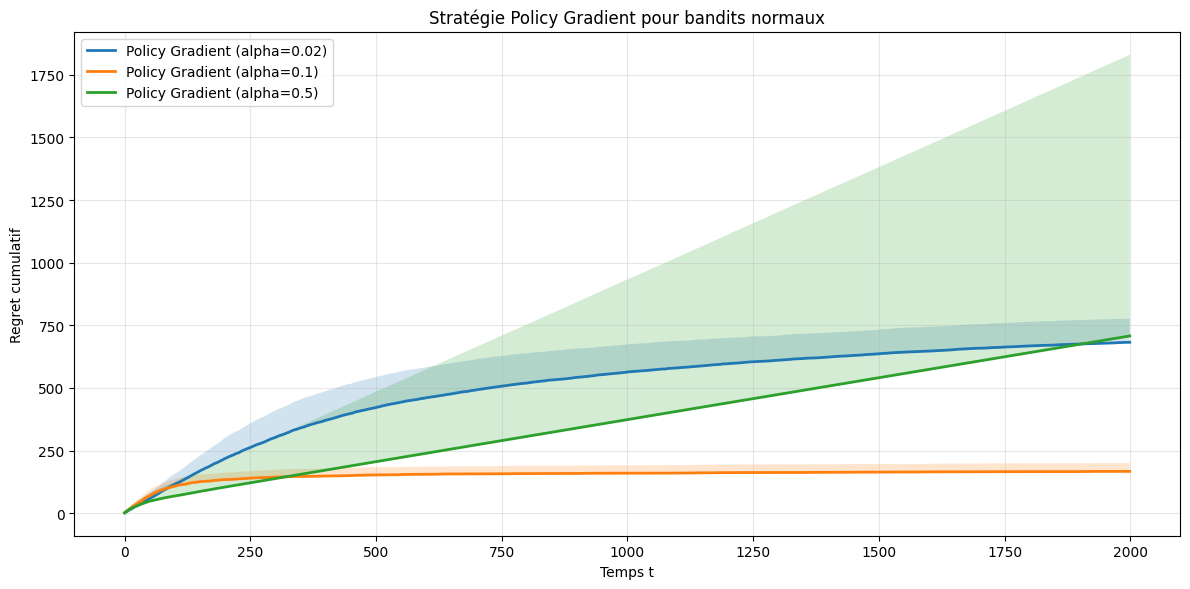

In [94]:
N = 10
T = 2000
sigma = 1

alphas = [1/50, 1/10, 1/2]

plt.figure(figsize=(12, 6))
for alpha in alphas:
    regrets_all = [policy_gradient(NormalBandit(np.random.normal(0, 1, 10), [sigma**2]*10, seed=i), T, alpha) for i in range(N)]
    mean_regrets = np.mean(regrets_all, axis=0)
    std_regrets = np.std(regrets_all, axis=0)


    plt.plot(mean_regrets, label=f"Policy Gradient (alpha={alpha})", linewidth=2)
    plt.fill_between(range(len(mean_regrets)), mean_regrets, mean_regrets + std_regrets, alpha=0.2)
    plt.xlabel("Temps t")
    plt.ylabel("Regret cumulatif")
    plt.title("Stratégie Policy Gradient pour bandits normaux")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
plt.show()

Discutez de l'impact du taux d'apprentissage en vous appuyant sur les résultats obtenus. Expliquez notamment la forme des courbes en référant au compromis entre l'exploration et l'exploitation.

Un alpha de 0.1 permet à l'agent d'arriver plus rapidement à la phase d'exploitation et la tendance de la courbe démontre clairement que l'action optimale est choisie plus souvent. En observant l'évolution de l'écart type on peut aussi déterminer qu'une ampleur moins grande de celui-ci pointe vers un choix de l'action optimale plus fréquent.

La courbe pour l'alpha 0.2 bien que le regret cumulatif connaît une croissance assez forte tend rapidement vers l'atteinte d'un plâteau. Encore une fois, l'ampleur de l'écart type laisse entrevoir un choix plus fréquent entre les actions optimales et sous optimales, laissant l'action avec l'espérance la plus faible de côté.

Finalement, la courbe avec un alpha de 0.5 a une croissance constante associée à l'écart type le plus important. Ces deux informations démontrent que l'exploration est nettement plus forte qu'avec alpha 0.1 et 0.2.

Chaque courbe à une transition décaler vers l'exploitation, plus le gradient est bas plus il prend du temps avant de passer en mode exploration, mais on vois aussi qu'il y a moins de regret cumuler durant la phase d'exploitation pour un gradient plus petit.

Un gradient élevé donne une transition rapide vers l'exploitation, mais risque de faire des erreurs et d'accumuler du regret long terme. Si on prolonge la ligne vert, elle dépassera la ligne bleu vers l'infini.

un gradient plus bas prolonge la phase d'exploration. ça permet de collecter plus de données sur chaque action avant de s'engager dans l'exploitation. La ligne bleu passe en exploitation beaucoup plus tard que la ligne orange, ce qui fait qu'elle acumule un speudo-regret au debut avant de se stabiliser.

## Les bandits stochastiques contextuels

### [10 points] Les environnements de bandits stochastiques linéaires

Vous travaillez dans une entreprise comprenant différents systèmes qui mériteraient d'être optimisés. Vous aimeriez investiguer le potentiel des stratégies de bandits stochastiques linéaires pour aborder la tâche d'ajustement des paramètres d'un système de manière à maximiser sa performance.

Complétez le code suivant pour implémenter un simulateur générique permettant de réaliser des expériences sur des problèmes de bandits stochastiques linéaires adaptés à cette application. Considérez que chaque récompense $R_t$ est générée en appliquant un bruit $\eta_t \sim \mathcal N(0, \sigma^2)$ à la fonction de performance évaluée à l'action $A_t$. Votre classe doit recevoir en entrée la fonction de caractéristiques à utiliser, le paramètre $\omega_\star$ gouvernant la fonction de récompense, la variance du bruit $\sigma^2$, la liste des actions discrètres considérées ($x_1, x_2, \dots, x_k$), ainsi qu'un germe aléatoire permettant de fixer la réalisation de l'instance. La fonction _play_ doit échantillonner et retourner une récompense pour l'action d'indice donné.

In [95]:
class LinGaussianBandit:
    def __init__(self, phi, omega, noise_variance, action_space, seed=None):
        self.phi = phi
        self.omega = omega
        self.noise_variance = noise_variance
        self.action_space = action_space
        self.rng = np.random.default_rng(seed)
        pass

    def play(self, action):
        phiCalcule = np.zeros(len(self.phi))
        for i in range(0,len(phi)):
            phiCalcule[i] = action_space[action]**self.phi[i]
        recompense = self.omega @ phiCalcule
        #print(recompense)
        return recompense + self.rng.normal(0, self.noise_variance)

Considérez une instance spécifique de cet environnement caractérisée par une variance du bruit $\sigma^2 = 0.01$, un espace d'action $\mathcal X$ fini et discret correspondant à 100 valeurs régulièrement espacées sur l'intervalle $[0, 1]$, la fonction de caractéristique $\varphi(x) = (1, x, x^2, x^3, x^4, x^5, x^6, x^7)$, ainsi que le paramètre $\omega_\star$ suivant : 

In [96]:
omega = np.array([0.41218989, 0.51717332, 0.40751546, 0.03405839, -0.29501341, -0.53931605, -0.07674824, -0.10778418])

Pour montrer que votre environnement fonctionne, présentez une réalisation de cette instance pour 50 actions sélectionnées aléatoirement sur $\mathcal X$. Votre figure devrait contenir la fonction de récompense attendue en plus des récompenses échantillonnées.

In [97]:
phi = np.array([0,1,2,3,4,5,6,7])
action_space = np.linspace(0,1,100)

#calcul récompense optimal attendue


recompenses = []
for action in action_space:
    phiCalcule = np.zeros(len(phi))
    for i in range(0,len(phi)):
        phiCalcule[i] = action**phi[i]
    recompenses.append(omega @ phiCalcule)


In [110]:
seed = 22
rng = np.random.default_rng(seed)
noise_variance = 0.01
linGaussianBandit = LinGaussianBandit(phi, omega, noise_variance, action_space, seed)
listeValeurAction = np.zeros(50)
listeRecompense = np.zeros(50)
for i in range(0, 50):
    actionJouee = rng.integers(0, len(action_space)-1)
    listeValeurAction[i] = action_space[actionJouee]
    listeRecompense[i] = linGaussianBandit.play(actionJouee)

indices = np.argsort(listeValeurAction)
listeValeurAction = listeValeurAction[indices]
listeRecompense = listeRecompense[indices]

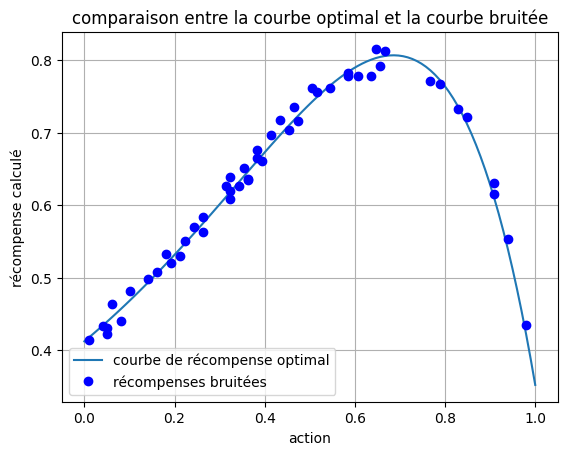

In [113]:
import numpy as np
import matplotlib.pyplot as plt

plt.plot(action_space, recompenses, label = "courbe de récompense optimal")
plt.plot(listeValeurAction, listeRecompense, "bo", label = "récompenses bruité")


plt.xlabel("action")
plt.ylabel("récompense calculé")
plt.title("comparaison entre la courbe optimal et la courbe bruitée")
plt.legend()
plt.grid(True)
plt.show()

À quoi pourrait correspondre le bruit dans cette application?

Le bruit peut correspondre à du chaos qui modifie le résultat d'une action aléatoirement. 

Un évenement inattendu ou un client étrange ou aberrant (chez amazon) qui ne correspond pas à notre modèle. 

### [15 points] OFUL

Complétez le code suivant pour implémenter la stratégie OFUL adaptée au type d'environnement décrit précédemment. Votre fonction doit recevoir en entrée l'instance de bandits stochastiques linéaires à aborder, la durée de l'horizon de temps $T$, le paramètre de régularisation $\lambda$, la variance du bruit $\sigma^2$, ainsi que la norme $\lVert \omega_\star \rVert_2$. Considérez que la première action effectuée ($A_1$) est choisie aléatoirement uniformément sur l'espace des actions et utilisez un niveau de confiance $\delta = 1/t$.

In [100]:
def phi_St_a_Calcule(action, action_space, phi):
    phiCalcule = np.zeros(len(phi))
    for i in range(0,len(phi)):
        phiCalcule[i] = action_space[action]**phi[i]
    return phiCalcule

def calculVecteurCaracteristique(action_space, phi):
    vecteurCaracteristic = np.zeros((len(action_space), len(phi)))
    for action in range(0,len(action_space)):
        vecteurCaracteristic[action] = phi_St_a_Calcule(action, action_space, phi)
    return vecteurCaracteristic

In [101]:
def oful(bandit, T, regularisation, noise_variance, norm_function):
    phi = np.array([0,1,2,3,4,5,6,7])

    omegaEtoile = np.array([0.41218989, 0.51717332, 0.40751546, 0.03405839, -0.29501341, -0.53931605, -0.07674824, -0.10778418])
    normeOmega = norm_function
    seed = 22
    linGaussianBandit = LinGaussianBandit(phi, omegaEtoile, noise_variance, bandit, seed)

    action_space = bandit
    d = len(omegaEtoile)
    sigma = 0.1 #à modifier
    Vt = (1 + regularisation * np.eye(d))
    b = np.zeros(len(omegaEtoile))

    rng = np.random.default_rng(seed)
    actionCourante = rng.choice(len(bandit))
    listeRegretCumulatif = np.zeros(T+1)
    vecteurCharacteristiques = calculVecteurCaracteristique(action_space, phi)
    normeVecteurCharacteristic = np.linalg.norm(vecteurCharacteristiques, axis = 1)
    L = np.max(normeVecteurCharacteristic)

    for pasDeTemps in range(1, T + 1):

        if pasDeTemps == 1 :

            recompenseActionCourante = linGaussianBandit.play(actionCourante)
            phiActuel = vecteurCharacteristiques[actionCourante]
            Vt += np.outer(phiActuel, phiActuel)
            b += recompenseActionCourante * phiActuel
            recompenseOptimale = np.max(vecteurCharacteristiques @ omegaEtoile)
            regretInstantane = recompenseOptimale - (phiActuel @ omegaEtoile)
            listeRegretCumulatif[pasDeTemps] = regretInstantane+ listeRegretCumulatif[pasDeTemps - 1]

        if (pasDeTemps > 1):

            #calcul nouvelle action=========================================================================================
            estimationOmega = np.linalg.solve(Vt, b)

            delta = 1/pasDeTemps
            L = np.max(normeVecteurCharacteristic)
            termeSpecial = (sigma * np.sqrt(d * np.log((1 + (pasDeTemps - 1)*L**2/regularisation)/delta)) + np.sqrt(regularisation) * normeOmega)
            produitScalaire = vecteurCharacteristiques @ estimationOmega
            V_inv = np.linalg.inv(Vt)
            normePonderee = np.sqrt(np.sum((vecteurCharacteristiques @ V_inv) * vecteurCharacteristiques, axis = 1))

            actionCourante = np.argmax(produitScalaire + normePonderee * termeSpecial)
            #calcul nouvelle action==========================================================================================

            recompenseActionCourante = linGaussianBandit.play(actionCourante)

            phiActuel = vecteurCharacteristiques[actionCourante]
            Vt += np.outer(phiActuel, phiActuel)
            b += recompenseActionCourante * phiActuel

            recompenseOptimale = np.max(vecteurCharacteristiques @ omegaEtoile)
            regretInstantane = recompenseOptimale - (phiActuel @ omegaEtoile)
            listeRegretCumulatif[pasDeTemps] = regretInstantane+ listeRegretCumulatif[pasDeTemps - 1]

    return listeRegretCumulatif

Comment se traduit le niveau de confiance $\delta$ considéré sur les intervalles de confiance considérés?

Réponse: l'intervalle de confiance grandit en ln(t^2). Ce qui signifie que plus les observations s'accumulent plus la confiance sur celles-ci sont grandes.



Appliquez la stratégie OFUL sur $N=100$ réalisations de l'instance de bandits stochastiques linéaires décrite précédemment, sur un horizon temporel $T = 1000$ en supposant que la variance du bruit $\sigma^2$ et la norme $\lVert \omega_\star \rVert_2$ sont des informations connues. Investiguez l'impact de la régularisation en considérant $\lambda \in \{ 0.001, 0.01, 0.1, 1 \}$.

Présentez vos résultats sous la forme de figures montrant le pseudo-regret cumulatif moyenné sur les réalisations, avec un écart-type au-dessus.

In [102]:
def applicationStrategieOFUL(realisation, T, tailleBandit, seed, regularisation):
    noise_variance = 0.01
    norm_function = 1
    listeRealisation = []

    for r in range(realisation):

        bandit = np.linspace(0,1,tailleBandit) #initialisation bandit
        regretCumulatif = oful(bandit, T, regularisation, noise_variance, norm_function)
        listeRealisation.append(regretCumulatif)
        seed += 1
    moyenneRegretCumulatif = np.mean(listeRealisation, axis = 0)
    ecartTypeRegretCumulatif = np.std(listeRealisation, axis = 0)

    return (moyenneRegretCumulatif, ecartTypeRegretCumulatif)

tailleBandit = 100
T = 1000
realisation = 100
seed = 22
regularisation = 10

moyenneRegretCumulatifLamda0001, ecartTypeRegretCumulatif0001 = applicationStrategieOFUL(realisation, T, tailleBandit, seed, regularisation = 0.001)
moyenneRegretCumulatifLamda001, ecartTypeRegretCumulatif001 = applicationStrategieOFUL(realisation, T, tailleBandit, seed, regularisation = 0.01)
moyenneRegretCumulatifLamda01, ecartTypeRegretCumulatif01 = applicationStrategieOFUL(realisation, T, tailleBandit, seed, regularisation = 0.1)
moyenneRegretCumulatifLamda1, ecartTypeRegretCumulatif1 = applicationStrategieOFUL(realisation, T, tailleBandit, seed, regularisation = 1)


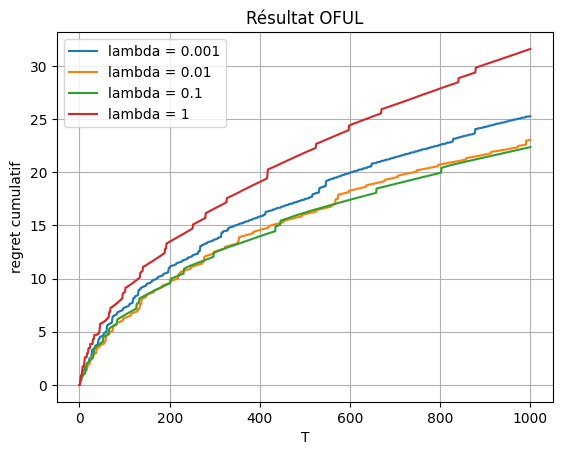

In [103]:
import numpy as np
import matplotlib.pyplot as plt

# points
x = np.arange(0, T + 1, 1)



# tracé
plt.plot(x, moyenneRegretCumulatifLamda0001, label="lambda = 0.001")
plt.fill_between(x, moyenneRegretCumulatifLamda0001, moyenneRegretCumulatifLamda0001 + ecartTypeRegretCumulatif0001, alpha=0.3)

plt.plot(x, moyenneRegretCumulatifLamda001, label="lambda = 0.01")
plt.fill_between(x, moyenneRegretCumulatifLamda001, moyenneRegretCumulatifLamda001 + ecartTypeRegretCumulatif001, alpha=0.3)

plt.plot(x, moyenneRegretCumulatifLamda01, label="lambda = 0.1")
plt.fill_between(x, moyenneRegretCumulatifLamda01, moyenneRegretCumulatifLamda01 + ecartTypeRegretCumulatif01, alpha=0.3)

plt.plot(x, moyenneRegretCumulatifLamda1, label="lambda = 1")
plt.fill_between(x, moyenneRegretCumulatifLamda1, moyenneRegretCumulatifLamda1 + ecartTypeRegretCumulatif1, alpha=0.3)



plt.xlabel("T")
plt.ylabel("regret cumulatif")
plt.title("Résultat OFUL")
plt.legend()
plt.grid(True)
plt.show()

Expliquez les résultats obtenus.

Les bris de continuité sur les courbes semblent démontrer que différentes actions sont explorés de façon séquentielle. De plus, la pente entre les bris semble constante. Quand une action atteint une certaine fréquences, une nouvelle est choisie. Ce choix se fait aussi vers l'action qui a un potentiel de récompense plus élevé. Les valeurs de lambda 1 et 0.001 offrent un potentiel d'apprentissage moins intéressant alors que les valeurs de 0.01 et 0.1 semble se confondre. Dans ce contexte des valeurs intermédiaires de lambda offre un potentiel d'apprentissage plus intéressant. L'écart type quasi nulle confirme l'hypothèse que les actions sont jouées de façon séquentielle à plusieurs reprises.

Une expérience avec un horizon de 10000 a été réalisée et nous avons constaté que la convergence vers l'action optimale n'était pas encore atteinte.


__[IFT-7201]__ En pratique, il peut arriver que la variance du bruit soit inconnue, donc qu'une estimation soit utilisée. Expliquez quel sera l'impact sur l'exploration et l'exploitation si la variance du bruit est sous/sur-estimée.

Seulement François Duguay-Giguère


le rayon de l'intervalle de confiance est proportionnel la variance du bruit. Cette augmentation de la confiance rapide va se traduire par un apprentissage moins rapide

Une sur-estimation de la variance augmente l'exploration ce qui ralentit la convergence, tandis qu'une sous-estimation réduit l'exploration, il risque donc de converger trop rapidement vers une solution qui est sous-optimale.

### [15 points] TS pour bandits stochastiques linéaires

Complétez le code suivant pour implémenter une stratégie TS linéaire adaptée au type d'environnement décrit précédemment. Votre fonction doit recevoir en entrée l'instance de bandits stochastiques linéaires à aborder, la durée de l'horizon de temps $T$, le paramètre de régularisation $\lambda$, ainsi que la variance du bruit $\sigma^2$. Considérez que la première action effectuée ($A_1$) est choisie aléatoirement uniformément sur l'espace des actions.

In [117]:
def lints(bandit, T, regularization, noise_variance):
    d = len(bandit.omega)
    
    V_inv = (1.0 / regularization) * np.identity(d)
    b = np.zeros((d, 1))
    
    rewards = []
    regrets = []

    for t in range(1, T + 1):
        # Échantillonnage
        theta_hat = V_inv @ b
        theta_t = np.random.multivariate_normal(theta_hat.flatten(), noise_variance * V_inv)

        best_arm = None
        max_value = -np.inf

        for action_idx in range(len(bandit.action_space)):
            phi_a = bandit.phi(bandit.action_space[action_idx]).reshape(-1, 1)
            value = phi_a.T @ theta_t.reshape(-1, 1)

            if value > max_value:
                max_value = value
                best_arm = action_idx

        reward = bandit.play(best_arm)
        rewards.append(reward)

        # Regret sans bruit 
        optimal_reward = np.max([np.dot(bandit.phi(a), bandit.omega) for a in bandit.action_space])
        chosen_reward_expected = np.dot(bandit.phi(bandit.action_space[best_arm]), bandit.omega)
        
        regrets.append(optimal_reward - chosen_reward_expected)

        # Mise à jour
        x = bandit.phi(bandit.action_space[best_arm]).reshape(-1, 1)
        V_inv_x = V_inv @ x
        denom = 1.0 + (x.T @ V_inv_x)
        V_inv -= (V_inv_x @ V_inv_x.T) / denom
        b += reward * x

    return np.cumsum(regrets)



Appliquez la stratégie LinTS sur $N=100$ réalisations de l'instance de bandits décrite précédemment, sur un horizon temporel $T = 1000$ en supposant que la variance du bruit est connue. Investiguez l'impact de la régularisation en considérant $\lambda \in \{ 0.001, 0.01, 0.1, 1 \}$.

Présentez vos résultats sous la forme de figures montrant le pseudo-regret cumulatif moyenné sur les réalisations, avec un écart-type au-dessus.

In [118]:
N = 10
T = 1000
sigma = 0.1
regularization_values = [0.001, 0.01, 0.1, 1.0] 

plt.figure(figsize=(10, 5))
for regu in regularization_values:
    all_regrets = [lints(LinGaussianBandit(phi, omega, noise_variance=sigma**2, action_space=np.linspace(0, 1, 100), seed=1), T, regularization=regu, noise_variance=sigma**2) for _ in range(N)]
    
    mean_regret = np.mean(all_regrets, axis=0)
    std_regret = np.std(all_regrets, axis=0)
    

    plt.plot(mean_regret, label=f'Regularisation={regu}', linewidth=2)
    plt.fill_between(range(len(mean_regret)), mean_regret, mean_regret + std_regret, alpha=0.2)
    plt.xlabel('Temps t')
    plt.ylabel('Regret cumulatif')
    plt.title(f'Performance de LinTS')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
plt.show()

TypeError: 'numpy.ndarray' object is not callable

<Figure size 1000x500 with 0 Axes>

You said
Discutez des résultats obtenus en comparaison avec les résultats obtenus en utilisant la stratégie OFUL.

L'algorithme LinTS affiche globalement un regret cumulatif final plus faible que OFUL pour les mêmes valeurs de régularisation, par contre il présente un écart-type beaucoup plus élevée, particulièrement visible pour lambda=1.0 où l'exploration aléatoire entraîne une instabilité marquée des performances initiales.